# Start building 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV,cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")
print(f"seaborn: {sns.__version__}")
import sklearn
print(f"scikit-learn: {sklearn.__version__}")

pandas: 2.3.0
numpy: 2.3.0
seaborn: 0.13.2
scikit-learn: 1.7.0


# start building my models
i see that there's 2 models 
1) is how fast do i run in general for a give distance, which this is the most boring one. 
2) is going forward if i use this model, how well can i forecast my next week of running. this would be the model that would try to learn from my training to predict what i could do 

In [ ]:
# removing time_minutes, calories, and elevation_low from features 
features= ['average_cadence',"max_cadence", 'average_heart_rate',
           'max_heart_rate' , 'max_speed_mph', 'distance_miles',
           "elevation_gain", "elevation_loss", "elevation_high"]

# removing the deactivated data points
run_data2_clean = run_data2[run_data2['deactivate'] == False].copy()

# setting the variables
X = run_data2_clean[run_data2_clean['deactivate'] == False][features]
y = run_data2_clean[run_data2_clean['deactivate'] == False]['pace']

# MAE scorer
#mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Negate since scikit-learn maximizes scores

mse_scorer = 'neg_mean_squared_error'
# 5-fold cross-validation
cv = 5

# --------------------
# lasso
lasso_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso(random_state=42))
])

lasso_params = {
    'lasso__alpha': np.array([
        5.e-3, 7.e-3, 9.e-3, 1.e-2, 3.e-2, 5.e-2, 7.e-2, 9.e-2,
        0.1, 0.3, 0.5, 0.7, 0.9, 1.0]),
    'lasso__max_iter': [2000]
}

lasso_grid = GridSearchCV(lasso_pipe, lasso_params, scoring=mse_scorer, cv=5)
lasso_grid.fit(X, y)
# results
print(f"Best Lasso MSE: {-lasso_grid.best_score_:.3f}| Best alpha: {lasso_grid.best_params_['lasso__alpha']}")
print(f"Best Params: {lasso_grid.best_params_}")

# --------------------
# 2. ridge
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

ridge_params = {
    "ridge__alpha": np.array([
        5.e-3, 7.e-3, 9.e-3, 1.e-2, 3.e-2, 5.e-2, 7.e-2, 9.e-2,
        0.1, 0.3, 0.5, 0.7, 0.9, 1.0]),
    'ridge__max_iter': [2000]
}

ridge_grid = GridSearchCV(ridge_pipe, ridge_params, scoring=mse_scorer, cv=cv)
ridge_grid.fit(X, y)
print(f"Ridge best MSE: {-ridge_grid.best_score_:.2f} | Best alpha: {ridge_grid.best_params_['ridge__alpha']}")
print(f"Best Params: {ridge_grid.best_params_}")


# --------------------
# 3. random forest
rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_grid = GridSearchCV(rf_model, rf_params, scoring=mse_scorer, cv=cv)
rf_grid.fit(X, y)
print(f"Random Forest best MSE: {-rf_grid.best_score_:.2f}")
print(f"Best params: {rf_grid.best_params_}")


Best Lasso MSE: 0.239| Best alpha: 0.005
Best Params: {'lasso__alpha': np.float64(0.005), 'lasso__max_iter': 2000}
Ridge best MSE: 0.24 | Best alpha: 0.7
Best Params: {'ridge__alpha': np.float64(0.7), 'ridge__max_iter': 2000}
Random Forest best MSE: 0.19
Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
# running the models with the best values 
X = run_data2_clean[features]
y = run_data2_clean['pace']

# 3. Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=41)

# 4. Define models in pipelines (scale for Lasso & Ridge)
models = {
    "Lasso": Pipeline([
        ("scaler", StandardScaler()),# standardizing the features
        ("model", Lasso(random_state=42, alpha = lasso_grid.best_params_['lasso__alpha']))
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()), # standardizing the features
        ("model", Ridge(random_state=42, alpha = ridge_grid.best_params_['ridge__alpha']))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, max_depth=None, min_samples_split=5)
}

# 5. Evaluate using cross_val_score with MAE
mse_scorer = 'neg_mean_squared_error'

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    print(f"{name} | MSE scores:{scores}")

Lasso | MSE scores:[-0.21023041 -0.16713136 -0.24202661 -0.20931927 -0.21851345]
Ridge | MSE scores:[-0.20114379 -0.16431756 -0.23249422 -0.21836973 -0.21794311]
Random Forest | MSE scores:[-0.14386253 -0.13192484 -0.19439448 -0.13717159 -0.16664818]


In [ ]:
results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    # Convert negative MSE to positive MSE for clarity
    positive_mse = -scores
    results.append(pd.DataFrame({
        'Model': name,
        'Fold': np.arange(1, len(scores)+1),
        'MSE': positive_mse
    }))

# Combine all results into one DataFrame
results_df = pd.concat(results)

# Boxplot to compare models
sns.boxplot(x='Model', y='MSE', data=results_df)
plt.title('Cross-Validation MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.show()

# Lineplot showing MSE per fold for each model
sns.lineplot(x='Fold', y='MSE', hue='Model', marker='o', data=results_df)
plt.title('Cross-Validation MSE per Fold')
plt.ylabel('Mean Squared Error')
plt.show()

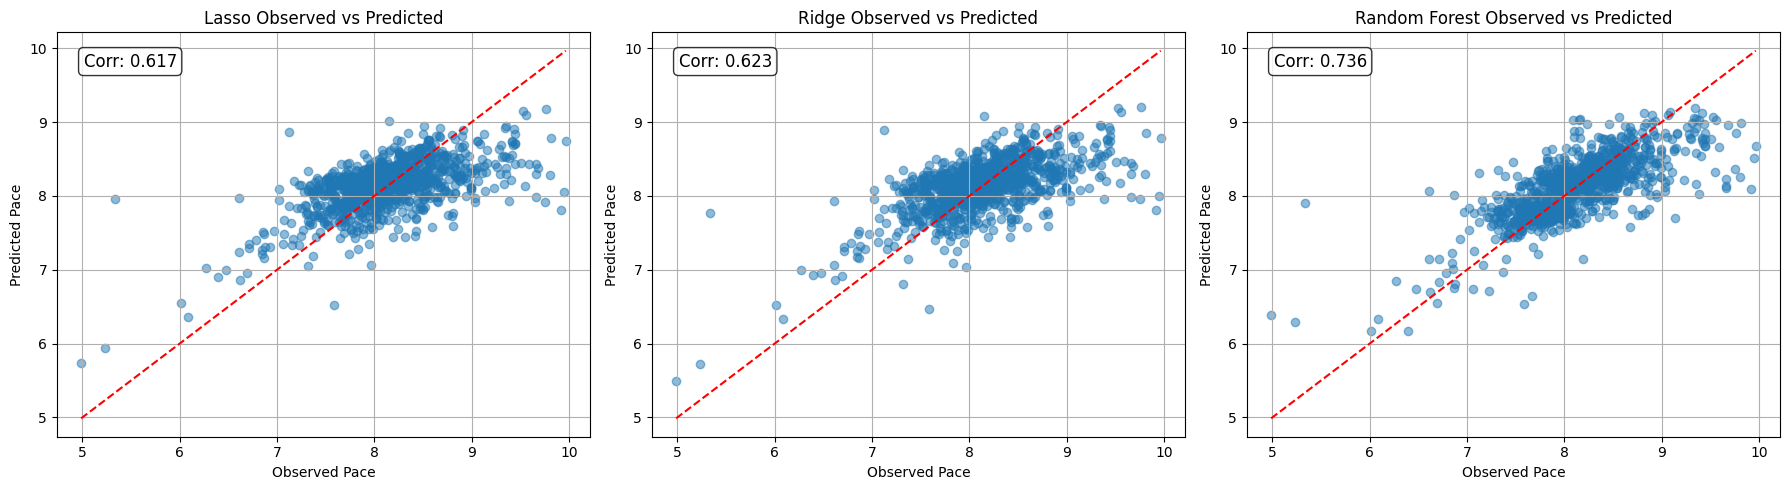

In [ ]:
plt.figure(figsize=(18, 5))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = cross_val_predict(model, X, y, cv=kf)
    
    # Calculate Pearson correlation
    corr, _ = stats.pearsonr(y, y_pred)
    
    plt.subplot(1, 3, i)
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
    plt.xlabel('Observed Pace')
    plt.ylabel('Predicted Pace')
    plt.title(f'{name} Observed vs Predicted')
    plt.grid(True)
    
    # Add correlation text in the plot
    plt.text(
        0.05, 0.95, f'Corr: {corr:.3f}', 
        transform=plt.gca().transAxes, 
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()


/var/folders/j1/vsq362wn6yb9ldgvb027flmw0000gp/T/ipykernel_63182/608650066.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


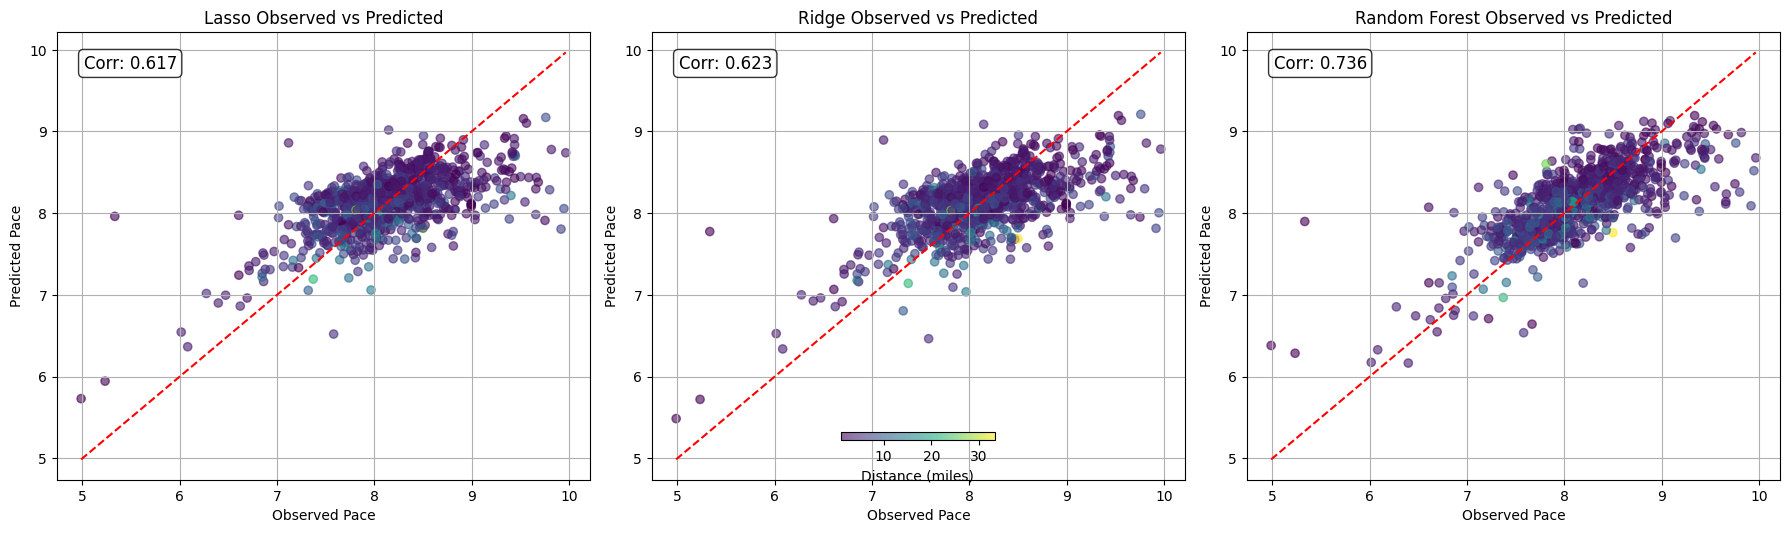

In [ ]:

plt.figure(figsize=(18, 5))

# Normalize distance for coloring
distances = run_data2_clean['distance_miles']
norm = plt.Normalize(distances.min(), distances.max())
cmap = plt.cm.viridis  # You can pick any matplotlib colormap

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = cross_val_predict(model, X, y, cv=kf)
    
    # Calculate Pearson correlation
    corr, _ = stats.pearsonr(y, y_pred)
    
    plt.subplot(1, 3, i)
    
    sc = plt.scatter(
        y, y_pred, 
        c=distances, 
        cmap=cmap, 
        norm=norm,
        alpha=0.6
    )
    
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # perfect prediction line
    plt.xlabel('Observed Pace')
    plt.ylabel('Predicted Pace')
    plt.title(f'{name} Observed vs Predicted')
    plt.grid(True)
    
    # Add correlation text
    plt.text(
        0.05, 0.95, f'Corr: {corr:.3f}', 
        transform=plt.gca().transAxes, 
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
# Add a colorbar for distance
cbar = plt.colorbar(sc, ax=plt.gcf().axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Distance (miles)')

plt.tight_layout()
plt.show()

In [ ]:
# Fit the best lasso pipeline on the full data
best_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=lasso_grid.best_params_['lasso__alpha'], random_state=42))
])

best_lasso.fit(X, y)

# Extract coefficients from the Lasso model
coefficients = best_lasso.named_steps['model'].coef_

# Combine feature names and coefficients in a DataFrame for easy viewing
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

print(coef_df)

              Feature  Coefficient
0     average_cadence    -0.236714
1         max_cadence     0.031658
2  average_heart_rate    -0.060719
3      max_heart_rate    -0.025645
4       max_speed_mph    -0.221995
5      distance_miles    -0.000000
6      elevation_gain     0.139188
7      elevation_loss    -0.082674
8      elevation_high     0.051259


1. Heart Rate × Pace

Higher pace → usually higher heart rate, but…
If you’re fit, you might hold a faster pace at a lower HR.
➤ Interaction tells us how efficient you are.

2. Cadence × Pace
Cadence (steps per minute) and pace are related.
Some runners increase cadence to go faster, others extend stride length.
➤ Interaction could help personalize what faster paces mean for you.

3. Elevation Gain × Heart Rate
More climbing = higher heart rate.
But if you’re well-trained on hills, your HR may stay relatively low.
➤ Interaction indicates terrain adaptation.

4. Elevation Gain × Pace
Obvious one: hilly runs are slower.
But how much slower? That may depend on your strength and training background.
➤ Modeling this helps normalize your pace for terrain.

5. Distance × Heart Rate

In [ ]:
run_data2['days_since_run'] = (run_data2['Activity Date'].max() - run_data2['Activity Date']).dt.days
run_data2['inv_distance'] = 1 / run_data2['distance_miles']
run_data2['log_distance'] = np.log(run_data2['distance_miles'])
run_data2['distance_squared'] = run_data2['distance_miles'] ** 2


/var/folders/j1/vsq362wn6yb9ldgvb027flmw0000gp/T/ipykernel_30939/181495843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data2['days_since_run'] = (run_data2['Activity Date'].max() - run_data2['Activity Date']).dt.days
/var/folders/j1/vsq362wn6yb9ldgvb027flmw0000gp/T/ipykernel_30939/181495843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_data2['inv_distance'] = 1 / run_data2['distance_miles']
/var/folders/j1/vsq362wn6yb9ldgvb027flmw0000gp/T/ipykernel_30939/181495843.py:3: SettingWithCopy